# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


## Import Packages

In [1]:
#importing OS to perform file read/write operations
import os
#import matplot , numpy and CV2 libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
# Import libraries required to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import display

%matplotlib inline

## Defining functions that i will use to plot the line(s)

In [2]:
'''
    Global states for intercepts, slopes and the top_y
'''
pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = np.array([])
top_y = np.array([])

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    auto = canny(image, lower, upper)
    return auto

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def yellow_to_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of yellow color in HSV
    upper_yellow = np.array([100, 255, 255]) 
    lower_yellow = np.array([80, 100, 100]) 

    # Threshold the HSV image to get only yellow colors
    mask_inverse = cv2.inRange(hsv, lower_yellow, upper_yellow)    
    masked_replace_white = cv2.addWeighted(img, 1, \
                                       cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB), 1, 0)
    #mask3 = np.dstack((mask_inverse, mask_inverse, mask_inverse)) 
    #max_image = cv2.max(img, mask3)

    return masked_replace_white


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:        
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    #print("Average : %%", total_pos_slope/pos_slope, total_neg_slope/neg_slope)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    extrapolate(line_img, lines)
    #draw_lines(line_img, lines)
    return line_img

def lines_linreg(lines_array):  
    '''
        Calculates the slope and intecept for line segments
    '''
    try:
        ### Select the 0th and 2nd index which will provide the xval and reshape to extract x values
        x = np.reshape(lines_array[:, [0, 2]], (1, len(lines_array) * 2))[0]
        #print('Reshape all x values into 1D Array.....')
        #print(x)
      
        ### Select the 1st and 3rd index which will provide the yval and reshape to extract 7 values
        y = np.reshape(lines_array[:, [1, 3]], (1, len(lines_array) * 2))[0]
        #print('Reshape all y values into 1D Array.....')
        #print(y)

        A = np.vstack([x, np.ones(len(x))]).T
        #print('result of vertical stacking of all x values.....')
        #print (A)
        m, c = np.linalg.lstsq(A, y)[0]
        #print (m,c)
        x = np.array(x)
        y = np.array(x * m + c).astype('int')
        #print (x)
        #print (y)
    except:
        print(x,y)
    return x, y, m, c

def mad(data, axis=None):
    return np.mean(np.abs(data - np.mean(data, axis)), axis)

def extrapolate(img, lines): 
    '''
        This function extrapolates the line segment consider the slope and intercept
        for the left and right line segments.
    '''
    global pos_global_slopes
    global pos_global_intercepts
    global neg_global_slopes
    global neg_global_intercepts
    global top_y
    #print('printing Detected hough lines......',lines)
    max_height = img.shape[0]
    max_width = img.shape[1]
    if lines == None:
        print("******************* No lines detected")
        return
    slopes = np.apply_along_axis(lambda row: (row[3] - row[1])/(row[2] - row[0]), 2, lines)
    #print('printing slopes for detected hough lines......',slopes)
    
    pos_slopes = slopes > 0.45
    pos_lines = lines[pos_slopes]
    #print ('Lines with Positive Slopes')
    #print (pos_lines)
    #print (len(pos_lines))

    neg_slopes = slopes < -0.45
    neg_lines = lines[neg_slopes]
    #print ('Lines with Negatvie Slopes')
    #print (neg_lines)
    #print (len(neg_lines))
    
    if len(pos_lines) == 0 or len(neg_lines) == 0:
        return;
    
    pos_x, pos_y, pos_m, pos_c = lines_linreg(pos_lines)
    #print('printing global positive slopes.....',pos_global_slopes)
    pos_global_slopes = np.append(pos_global_slopes, [pos_m])
    #print('printing global positive slopes.....',pos_global_slopes)
    #print('printing global positive intercepts.....',pos_global_intercepts)
    pos_global_intercepts = np.append(pos_global_intercepts, [pos_c])
    #print('printing global positive intercepts.....',pos_global_intercepts)

    #print("Before adjusting slopes : %f intercept %f" % (pos_m, pos_c))
    pos_m = pos_global_slopes[-20:].mean()
    pos_c = pos_global_intercepts[-20:].mean()
    
       
    #print("------------")
    
    neg_x, neg_y, neg_m, neg_c = lines_linreg(neg_lines)
    neg_global_slopes = np.append(neg_global_slopes, [neg_m])
    neg_global_intercepts = np.append(neg_global_intercepts, [neg_c])
    neg_m = neg_global_slopes[-20:].mean()
    neg_c = neg_global_intercepts[-20:].mean()
    
    bottom_left_y = img.shape[0]
    bottom_left_x = int((bottom_left_y - neg_c)/neg_m)
    #print(bottom_left_y, bottom_left_x)
    
    min_top_y = np.min([neg_y.min(), pos_y.min()])
    top_y = np.append(top_y, [min_top_y])
    min_top_y = int(top_y[-20:].mean())
    top_left_y = min_top_y
    top_left_x = int((top_left_y - neg_c)/neg_m)
    
    top_right_y = min_top_y
    top_right_x = int((top_right_y - pos_c)/pos_m)
    
    bottom_right_y = img.shape[0]
    bottom_right_x = int((bottom_right_y - pos_c)/pos_m)
    
    #Average    
    cv2.line(img, (bottom_left_x, bottom_left_y), (top_left_x, top_left_y), [0, 0, 255], 10)
    cv2.line(img, (top_right_x, top_right_y), (bottom_right_x, bottom_right_y), [0, 0, 255], 10)

    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# I will now define my PIPELINE to do the following ...
## Convert all yellow lines in the image to white
## Then convert the image to GrayScale
## Reduce noise through Gaussian Blur Adjustment
## Edge Detection using Canny
## Narrow down to region of interest
## Identify line segments using Hough
## Extrapolate left and right line segments and line fitment through least squares method
## Add weight to extrapolated lines


In [3]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    converted = yellow_to_white(image)
    print('After Yellow to White Conversion.....')
    plt.imshow(converted)
    plt.show()
    
    max_width = image.shape[1]
    max_height = image.shape[0]
    sample_image = np.copy(converted)
    width_delta = int(max_width/30)
    vertices = np.array([[(100, max_height), (max_width - 100, max_height), (max_width/2 + width_delta, max_height/2 + 50), (max_width/2 - width_delta, max_height/2 + 50)]], np.int32)
    #vertices = np.array([[(0, max_height), (max_width - 0, max_height), (max_width/2 + width_delta, max_height/2 + 100), (max_width/2 - width_delta, max_height/2 + 100)]], np.int32)

    gray_scaled = grayscale(sample_image)
    print('Post Gray Scaling .....')
    plt.imshow(gray_scaled)
    plt.show()
    
    blur_adj_img = gaussian_blur(gray_scaled, 5)
    print('Post Gaussian Blur Adjustment.....')
    plt.imshow(blur_adj_img)
    plt.show()
    
    #cimage = canny(blurred_img, 50, 250)
    # Use auto_canny instead.
    cimage = auto_canny(blur_adj_img)
    print('After Canny Edge Detection.....')
    plt.imshow(cimage)
    plt.show()
    
    tmp = np.copy(cimage)
    selected = region_of_interest(cimage, vertices)
    print('Locking Region of Interest.....')
    plt.imshow(selected)
    plt.show()
    
    fin = hough_lines(selected, 1, 1 * np.pi/180, 20, 5, 5)

    result = weighted_img(fin, image, α=0.8, β=1., λ=0.)

    return result

# Now i will process the still images in folder 'test_images'

_______________________________________________
Processing file ....... solidWhiteCurve.jpg
_______________________________________________
After Yellow to White Conversion.....


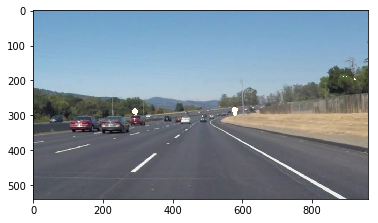

Post Gray Scaling .....


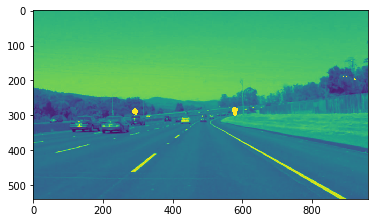

Post Gaussian Blur Adjustment.....


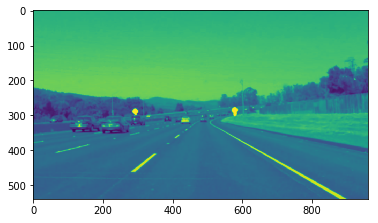

After Canny Edge Detection.....


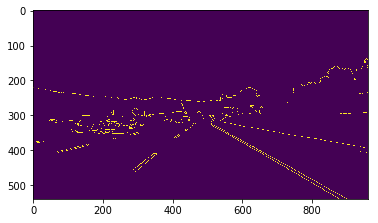

Locking Region of Interest.....


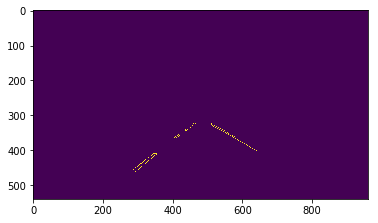

Final Line Fitment.....


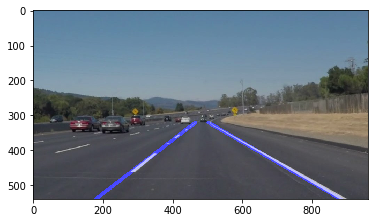

_______________________________________________
Processing file ....... solidWhiteRight.jpg
_______________________________________________
After Yellow to White Conversion.....


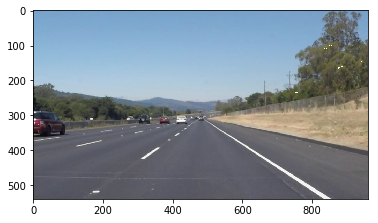

Post Gray Scaling .....


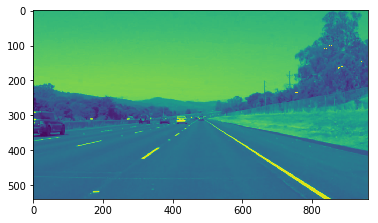

Post Gaussian Blur Adjustment.....


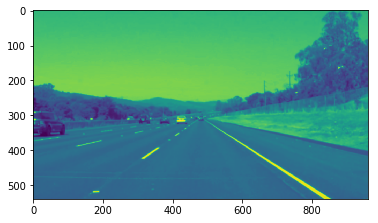

After Canny Edge Detection.....


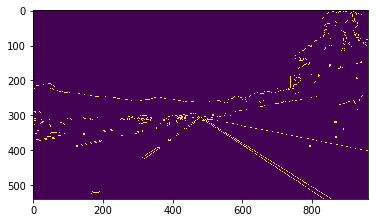

Locking Region of Interest.....


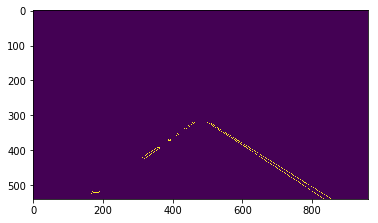

Final Line Fitment.....


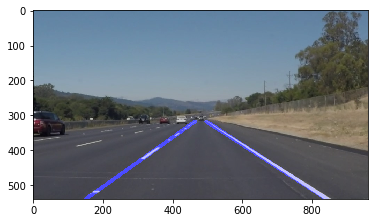

_______________________________________________
Processing file ....... solidYellowCurve.jpg
_______________________________________________
After Yellow to White Conversion.....


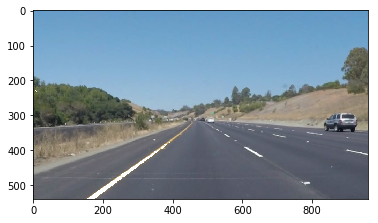

Post Gray Scaling .....


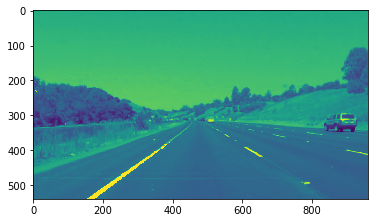

Post Gaussian Blur Adjustment.....


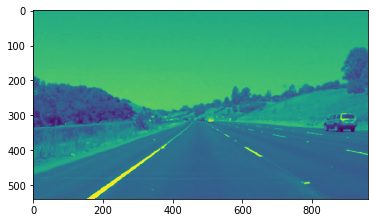

After Canny Edge Detection.....


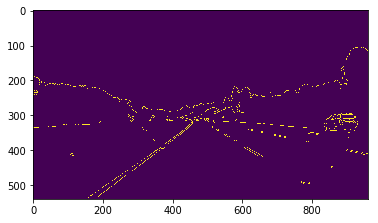

Locking Region of Interest.....


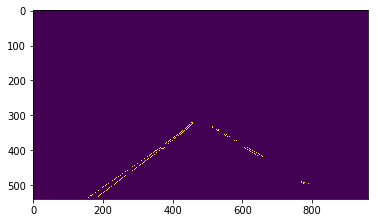

Final Line Fitment.....


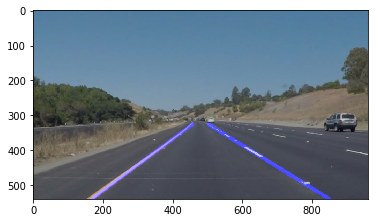

_______________________________________________
Processing file ....... solidYellowCurve2.jpg
_______________________________________________
After Yellow to White Conversion.....


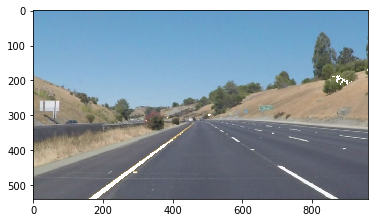

Post Gray Scaling .....


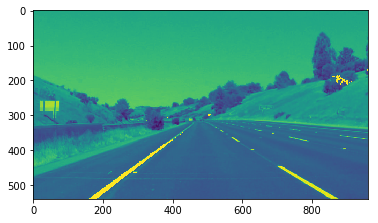

Post Gaussian Blur Adjustment.....


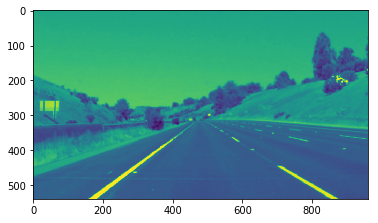

After Canny Edge Detection.....


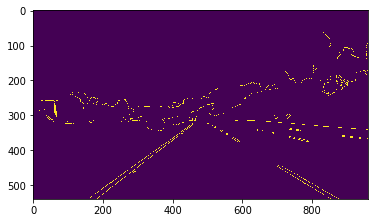

Locking Region of Interest.....


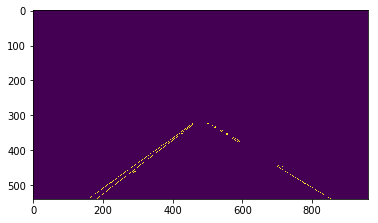

Final Line Fitment.....


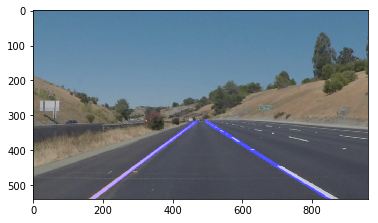

_______________________________________________
Processing file ....... solidYellowLeft.jpg
_______________________________________________
After Yellow to White Conversion.....


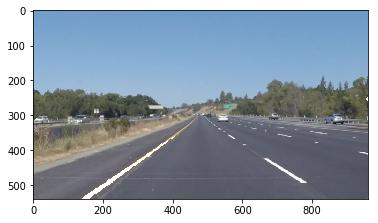

Post Gray Scaling .....


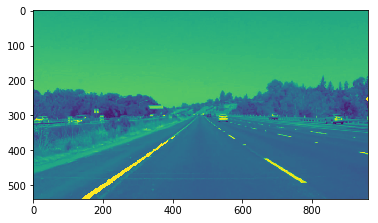

Post Gaussian Blur Adjustment.....


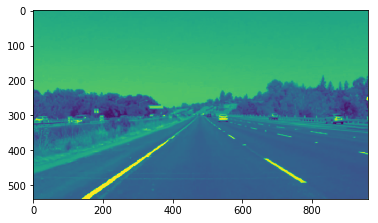

After Canny Edge Detection.....


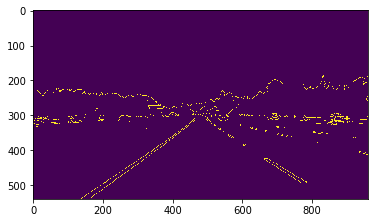

Locking Region of Interest.....


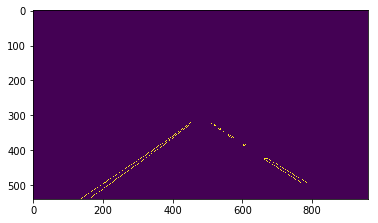

Final Line Fitment.....


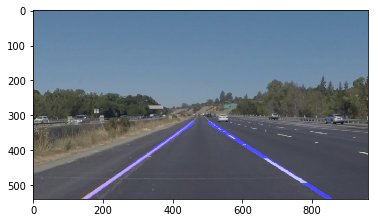

_______________________________________________
Processing file ....... Thumbs.db
_______________________________________________


OSError: cannot identify image file 'test_images/Thumbs.db'

In [4]:

imgs = []
for img in os.listdir("test_images/"):
    print('_______________________________________________')
    print('Processing file .......',img)
    print('_______________________________________________')
    pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = np.array([])
    top_y = np.array([])
    
    test_image = mpimg.imread('test_images/'+img)
    t = process_image(test_image)
    print('Final Line Fitment.....')
    plt.imshow(t)
    plt.show()

# Now I will define a copy of  my above pipeline but this time without any print      statements


In [5]:
def process_video_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    converted = yellow_to_white(image)
    #print('After Yellow to White Conversion.....')
    #plt.imshow(converted)
    #plt.show()
    
    max_width = image.shape[1]
    max_height = image.shape[0]
    sample_image = np.copy(converted)
    width_delta = int(max_width/30)
    vertices = np.array([[(100, max_height), (max_width - 100, max_height), (max_width/2 + width_delta, max_height/2 + 50), (max_width/2 - width_delta, max_height/2 + 50)]], np.int32)
    #vertices = np.array([[(0, max_height), (max_width - 0, max_height), (max_width/2 + width_delta, max_height/2 + 100), (max_width/2 - width_delta, max_height/2 + 100)]], np.int32)

    gray_scaled = grayscale(sample_image)
    #print('Post Gray Scaling .....')
    #plt.imshow(gray_scaled)
    #plt.show()
    
    blur_adj_img = gaussian_blur(gray_scaled, 5)
    #print('Post Gaussian Blur Adjustment.....')
    #plt.imshow(blur_adj_img)
    #plt.show()
    
    #cimage = canny(blurred_img, 50, 250)
    # Use auto_canny instead.
    cimage = auto_canny(blur_adj_img)
    #print('After Canny Edge Detection.....')
    #plt.imshow(cimage)
    #plt.show()
    
    tmp = np.copy(cimage)
    selected = region_of_interest(cimage, vertices)
    #print('Locking Region of Interest.....')
    #plt.imshow(selected)
    #plt.show()
    
    fin = hough_lines(selected, 1, 1 * np.pi/180, 20, 5, 5)

    result = weighted_img(fin, image, α=0.8, β=1., λ=0.)

    return result

# Now i will process video -- SolidWhiteRight.MP4

In [6]:

pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = top_y =  np.array([])

white_output = 'solidWhiteRight_output.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_video_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video solidWhiteRight_output.mp4
[MoviePy] Writing video solidWhiteRight_output.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 36.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight_output.mp4 

Wall time: 6.67 s


In [7]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Now i will process video -- SolidYellowLeft.MP4

In [8]:

pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = top_y =  np.array([])

yellow_output = 'solidYellowLeft_output.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_video_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video solidYellowLeft_output.mp4
[MoviePy] Writing video solidYellowLeft_output.mp4


100%|███████████████████████████████████████▉| 681/682 [00:19<00:00, 37.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidYellowLeft_output.mp4 

Wall time: 20.1 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Now i will process video -- challenge.MP4

In [10]:
pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = top_y =  np.array([])

challenge_output = 'challenge_output.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_video_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|████████████████████████████████████████| 251/251 [00:14<00:00, 17.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

Wall time: 15.7 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges,cmap='Greys_r')

In [ ]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255 
# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(440, 325), (500,325), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges)


In [ ]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 5     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 10   # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
plt.imshow(line_image)

In [ ]:
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)